In [277]:
import os
import xml.etree.ElementTree as ET
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import pprint

Let's define some utility functions, first:

In [278]:
# extracts the configurations/information of a trial from it's .xml file. We will see how to use it in the examples
def extract_trial_info(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    task = root.findall("task")
    batch = task[0].text.split(" | ")[0].strip().split("_")[1]
    trial_number = task[0].text.split(" | ")[0].strip().split("_")[3]
    slug = task[0].text.split(" | ")[1].strip()

    info_dict = {'date': root.find("date").text,
                 'user-agent': root.find("ua").text,
                 'batch': int(batch),
                 'trial-number': int(trial_number),
                 'slug': slug,
                 'screen-width': int(root.find("screen").text.split('x')[0]),
                 'screen-height': int(root.find("screen").text.split('x')[1]),
                 'window-width': int(root.find("window").text.split('x')[0]),
                 'window-height': int(root.find("window").text.split('x')[1]),
                 'document-width': int(root.find("document").text.split('x')[0]),
                 'document-height': int(root.find("document").text.split('x')[1]),
                 }

    return info_dict

# loads a python dictionary from a .json file
def load_dict_from_file(file_path):
    with open(file_path, "r") as f:
        dict_obj = json.load(f)
    return dict_obj

def plot_image(cv2_image, dpi=500):
    plt.axis("off")
    plt.rcParams['figure.dpi'] = dpi
    plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))
    plt.show()

Now, let's select one of the trials:

In [ ]:
trial_id = 'p005-b6-t3' # without extention (e.g. .json, .xml, .png)

And then let's to specify the directories of different kinds of data we have:

In [ ]:
# You should change this value based on the location of the data on your machine
data_dir = '/paht/to/data'

trials_info_data_dir = os.path.join(data_dir, 'trial-metadata') # File names pattern in this dir: [trial_id] + '.xml'

eye_tracking_annotated_data_dir = os.path.join(data_dir, 'fixation-data') # File names pattern in this dir: [trial_id] + '.csv'

mouse_tracking_data_dir = os.path.join(data_dir, 'mouse-movement-data') # File names pattern in this dir: [trial_id] + '.csv'

ads_boundaries_data_dir = os.path.join(data_dir, 'ad-boundary-data') # File names pattern in this dir: [trial_id] + '.json'

screenshots_data_dir = os.path.join(data_dir, 'full-page-screenshots') # File names pattern in this dir: [trial_id] + '.png'

visualizations_data_dir = 'path/to/mousemovements-visualizations'  # includes sub-folders, we will see in the examples

## How to extract the trial's information/configuration?


In [ ]:
trial_info_file_path = os.path.join(trials_info_data_dir, (trial_id + '.xml'))

trial_info = extract_trial_info(trial_info_file_path)

pprint.pprint(trial_info)

{'batch': 31,
 'date': '12/16/2022 17:03:55',
 'document-height': 2423,
 'document-width': 1403,
 'screen-height': 1024,
 'screen-width': 1280,
 'slug': 'buy-longacre-longacre-50450-tire-gauge',
 'trial-number': 3,
 'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36',
 'window-height': 1137,
 'window-width': 1422}


### An example: how to get the width of the screen?

In [282]:
print(trial_info['screen-width'])

1280


## How to retrieve the corresponding screenshot?

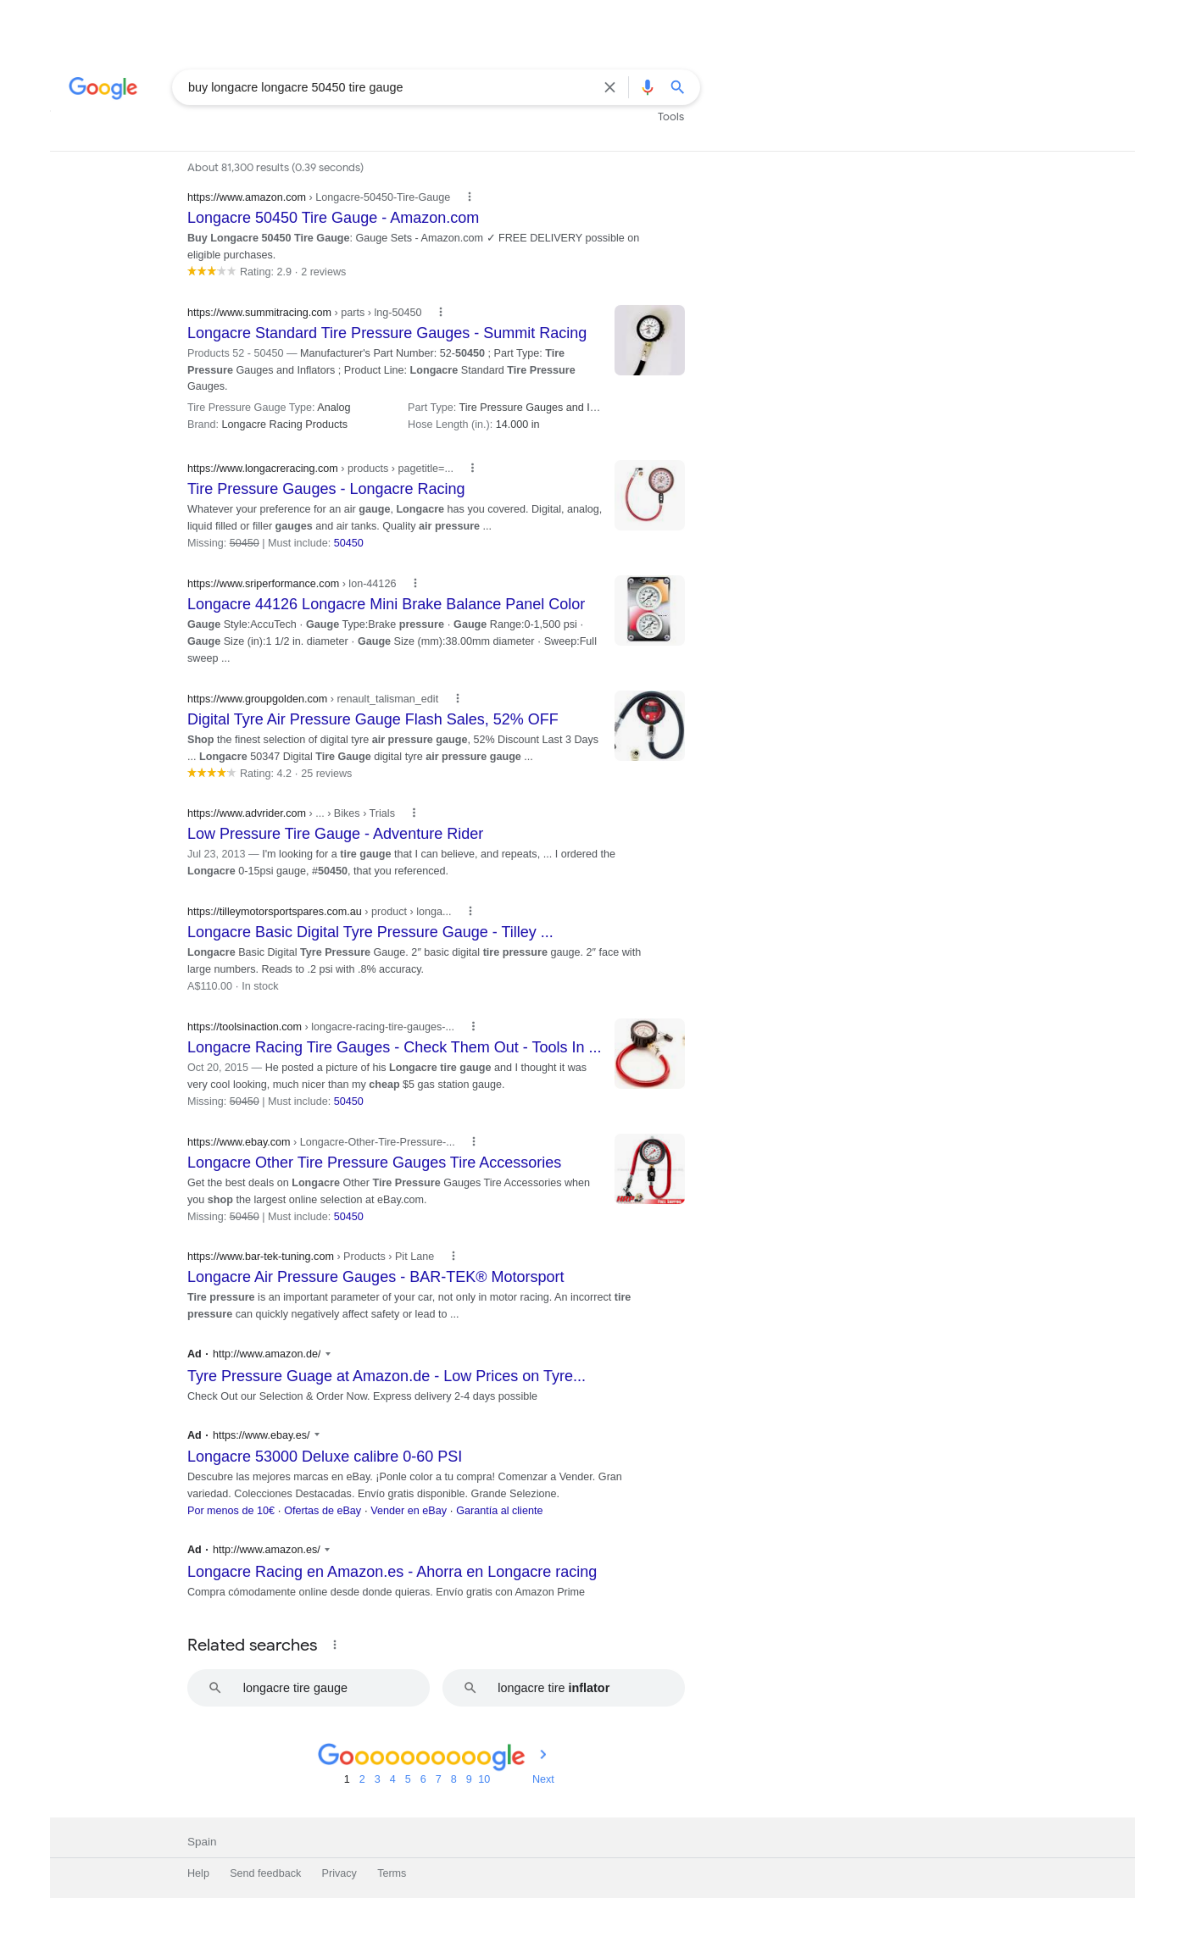

In [283]:
screenshot_img_path = os.path.join(screenshots_data_dir, (trial_id + '.png'))
screenshot_img = cv2.imread(screenshot_img_path)
plot_image(screenshot_img)

## How to retrieve the boundaries of ads on the screenshot?

In [ ]:
trial_ads_boundaries_file_path = os.path.join(ads_boundaries_data_dir, trial_id + '.json')

trial_ads_boundaries_dict = load_dict_from_file(trial_ads_boundaries_file_path)

pprint.pprint(trial_ads_boundaries_dict)

{'dd_right': [],
 'dd_top': [],
 'native_ad': [{'location': {'x': 162, 'y': 1530},
                'size': {'height': 69, 'width': 540}},
               {'location': {'x': 162, 'y': 1625},
                'size': {'height': 108, 'width': 540}},
               {'location': {'x': 162, 'y': 1761},
                'size': {'height': 69, 'width': 540}}]}


### Drawing the boundaries of ads on the screenshot:

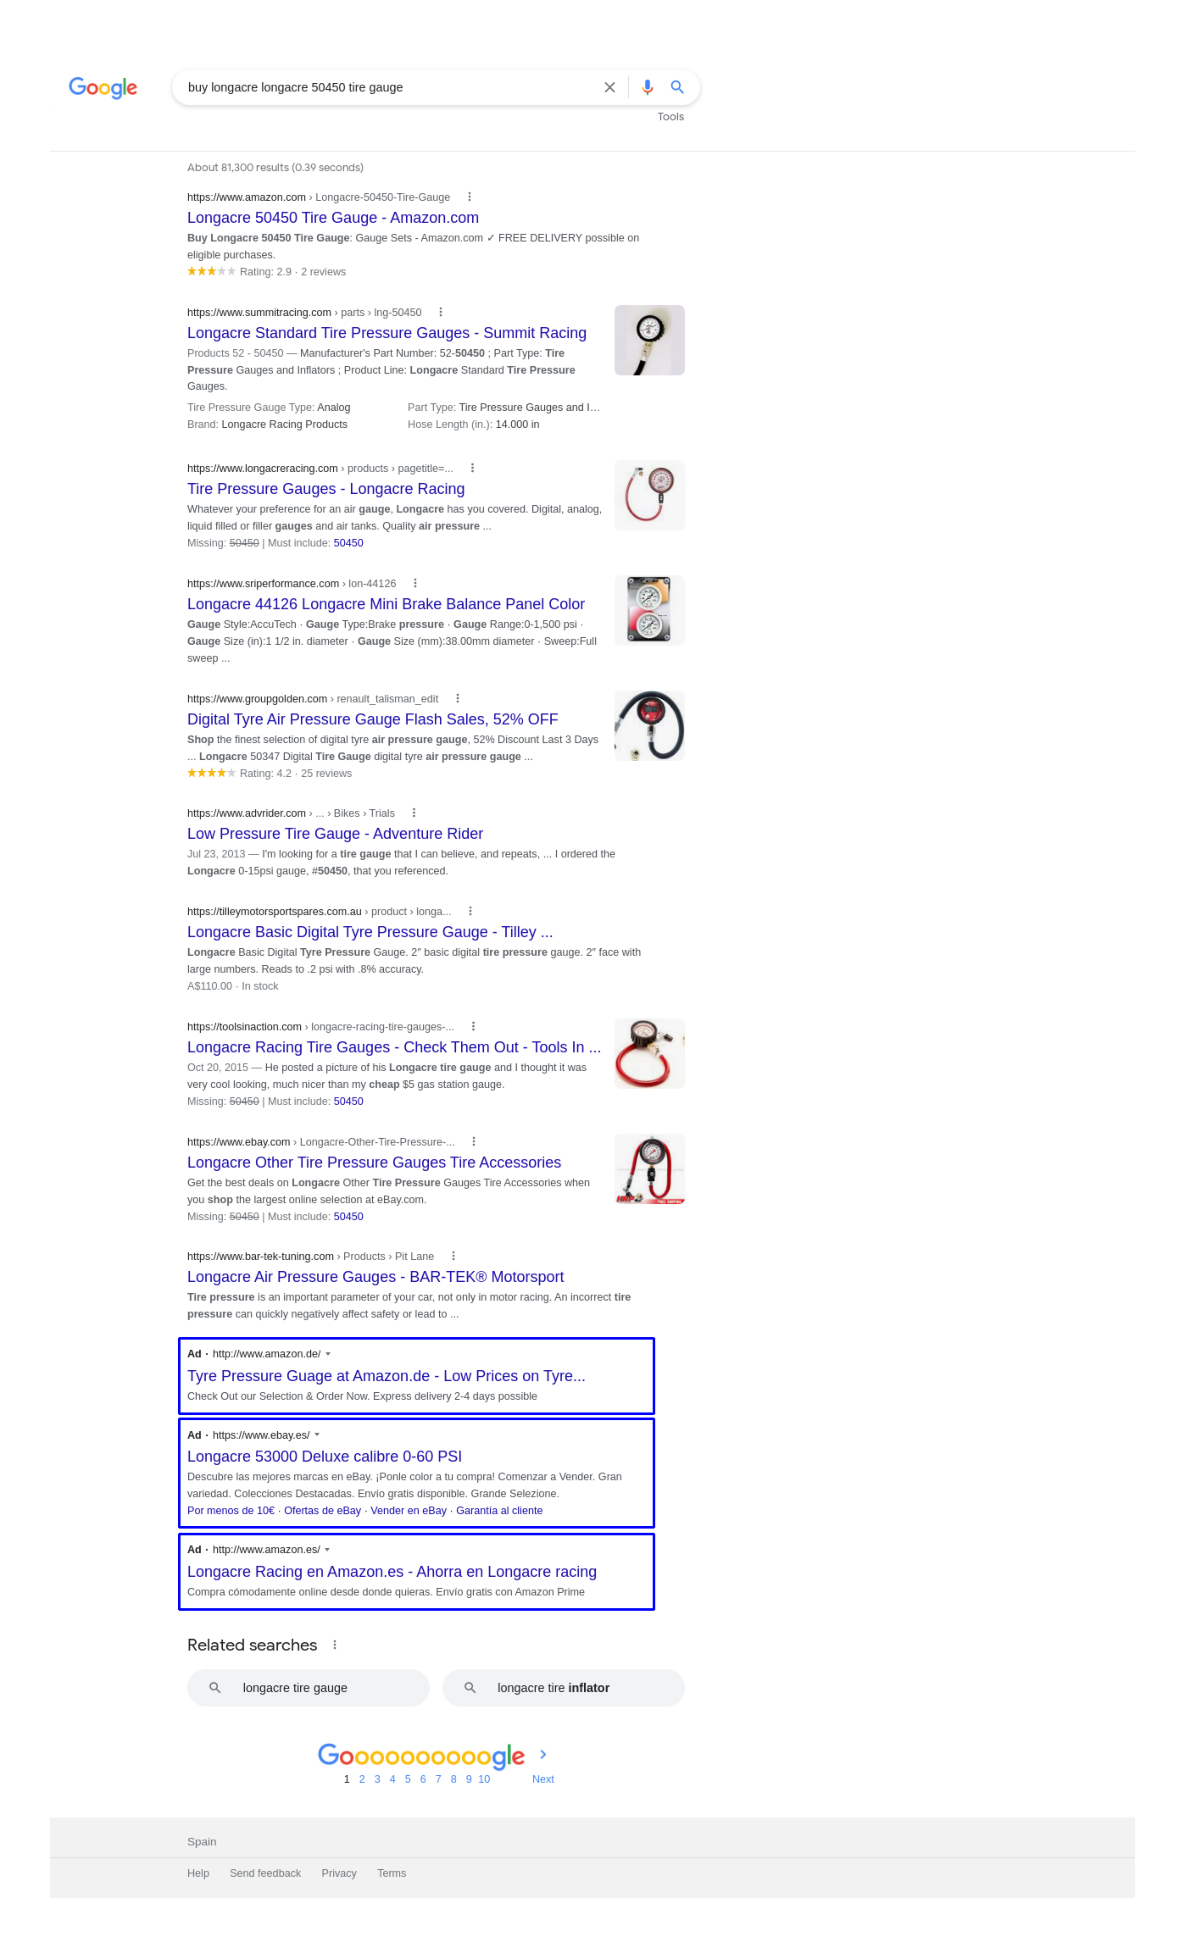

In [ ]:
# let's consider a unique color for each type of ads
ad_colors = {'native_ad': (255, 0, 0) , 'dd_top': (0, 255, 0), 'dd_right': (0, 0, 255)}
for ad_type in trial_ads_boundaries_dict:
    for ad in trial_ads_boundaries_dict[ad_type]:
        x, y = ad['location']['x'], ad['location']['y']
        width, height = ad['size']['width'], ad['size']['height']
        color = ad_colors[ad_type]
        thickness = 2  
        
        # Adjust coordinates to include padding
        top_left = (x, y)
        bottom_right = (x + width, y + height)
        
        # Draw the rectangle with padding
        cv2.rectangle(screenshot_img, top_left, bottom_right, color, thickness)

plot_image(screenshot_img)

## How to read eye-tracking file

In [286]:
trial_eye_tracking_file_path = os.path.join(eye_tracking_annotated_data_dir, (trial_id + '.csv'))
eye_tracking_df = pd.read_csv(trial_eye_tracking_file_path, delimiter=',')

print(eye_tracking_df.columns)

Index(['timestamp', 'FPOGX', 'FPOGY', 'FPOGD'], dtype='object')


### Drawing fixation points on the corresponding screenshot (with ad boundaries)

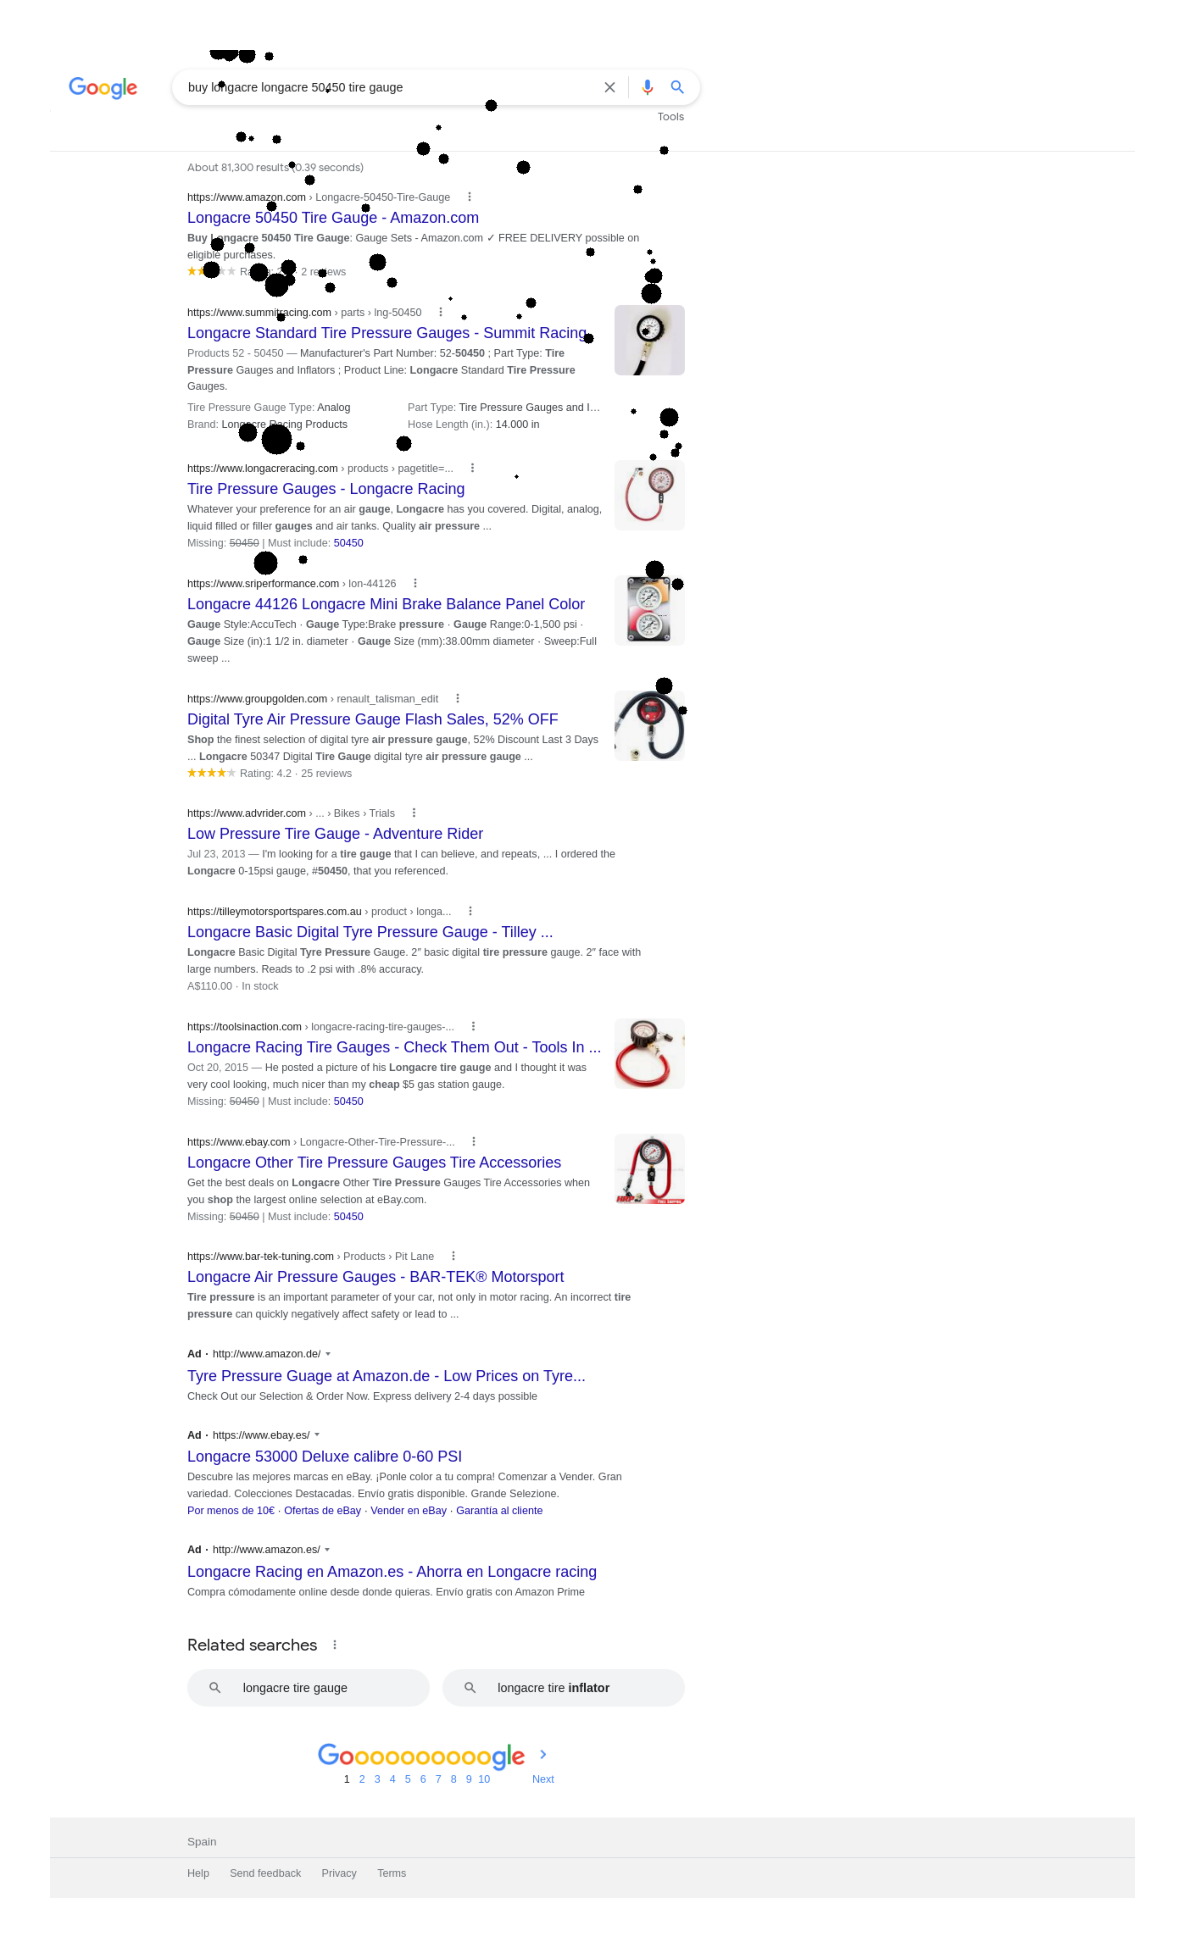

In [287]:
screenshot_img_path = os.path.join(screenshots_data_dir, (trial_id + '.png'))
screenshot_img = cv2.imread(screenshot_img_path)

for index, row in eye_tracking_df.iterrows():
    x = row['FPOGX']
    y = row['FPOGY']
    duration = row['FPOGD']
    color = (0, 0, 0)
    cv2.circle(screenshot_img, (x, y), int(0.03*duration), color, -1)

plot_image(screenshot_img)

In [288]:
mt_data_df = pd.read_csv(os.path.join(mouse_tracking_data_dir, trial_id + '.csv'))
print(mt_data_df.columns)

Index(['timestamp', 'xpos', 'ypos', 'event', 'xpath'], dtype='object')


In [289]:
# screen size of the monitor
display_width = 1280
display_height = 1024

# window size of the web browser
win_width = trial_info['window-width']
win_height = trial_info['window-height']

# extract those rows of data that a mousemove happend
mt_data_df = mt_data_df[mt_data_df['event'].isin(['mousemove', 'mouseover'])]

# converting the xs, ys to absolute positions on the corresponding screenshot
for index, row in mt_data_df.iterrows():
    ratio_x = row['xpos']/win_width
    ratio_y = row['ypos']/win_height
    mt_data_df.loc[index, 'xpos'] = int(display_width*ratio_x)
    mt_data_df.loc[index, 'ypos'] = int(display_height*ratio_y)


# let's get each column as a list of values
timestamps = mt_data_df['timestamp'].values
events = mt_data_df['event'].values
cursor_xs = mt_data_df['xpos'].values
cursor_ys = mt_data_df['ypos'].values
xpaths = mt_data_df['xpath'].values


### Drawing the trajectories of the mouse-movements

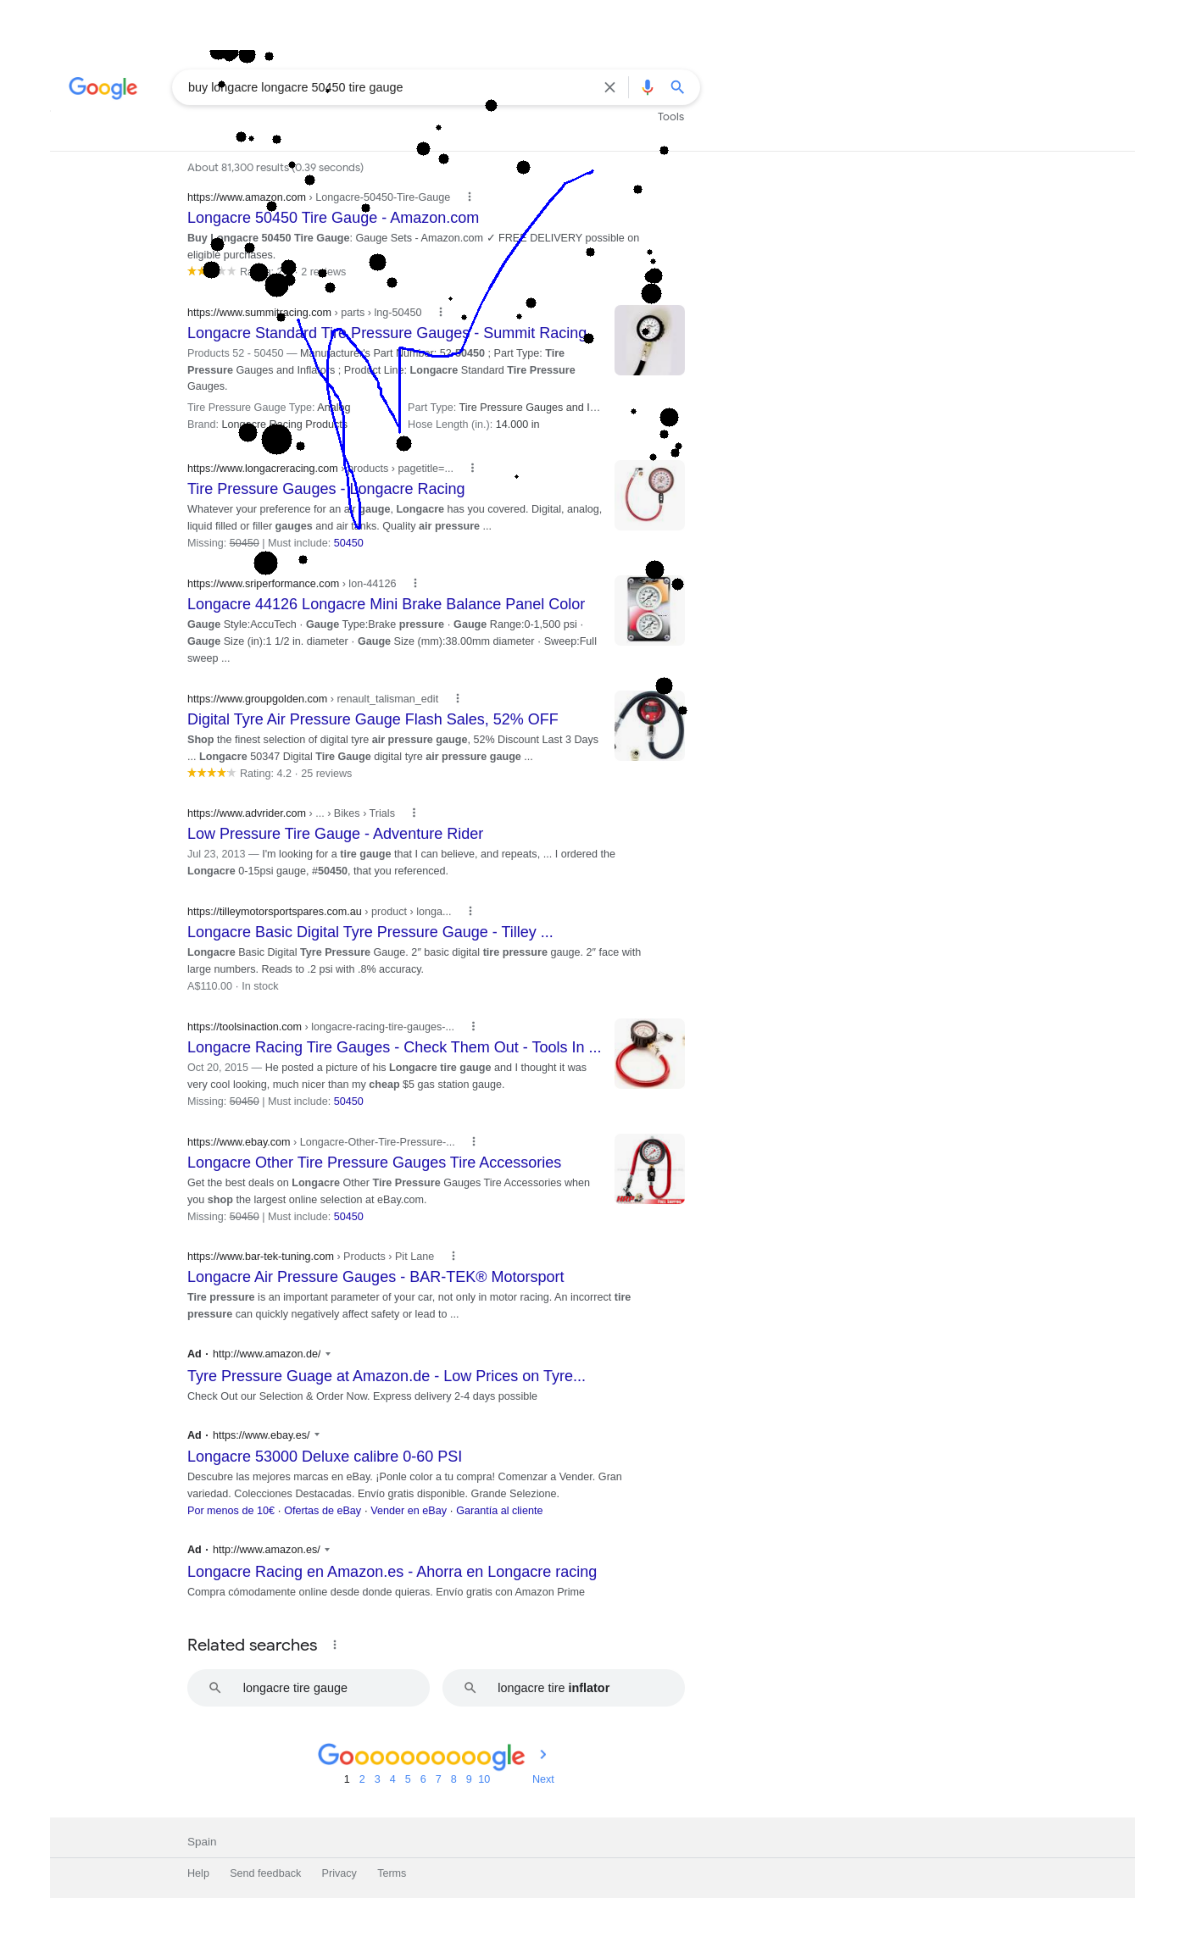

In [290]:
for i in range(len(cursor_xs)-1):
    # Convert the x and y coordinates to integers
    x1, y1 = int(cursor_xs[i]), int(cursor_ys[i])
    x2, y2 = int(cursor_xs[i+1]), int(cursor_ys[i+1])
    # draw a blue line between the points
    cv2.line(screenshot_img, (x1, y1), (x2, y2), (255, 0, 0), 2)


plot_image(screenshot_img)


## Visualizations

We provided below visualisations for mouse-tracking:
    
* Heatmaps

* Trajectories

* Colored-trajectories

* Trajectories with variable line-thickness

* Colored trajectories with_variable line thickness

* Heatmaps

There is no need to calculate things, just load the correspoing visulisations using th trial_id!

For example for colored trajectories with_variable line thickness:

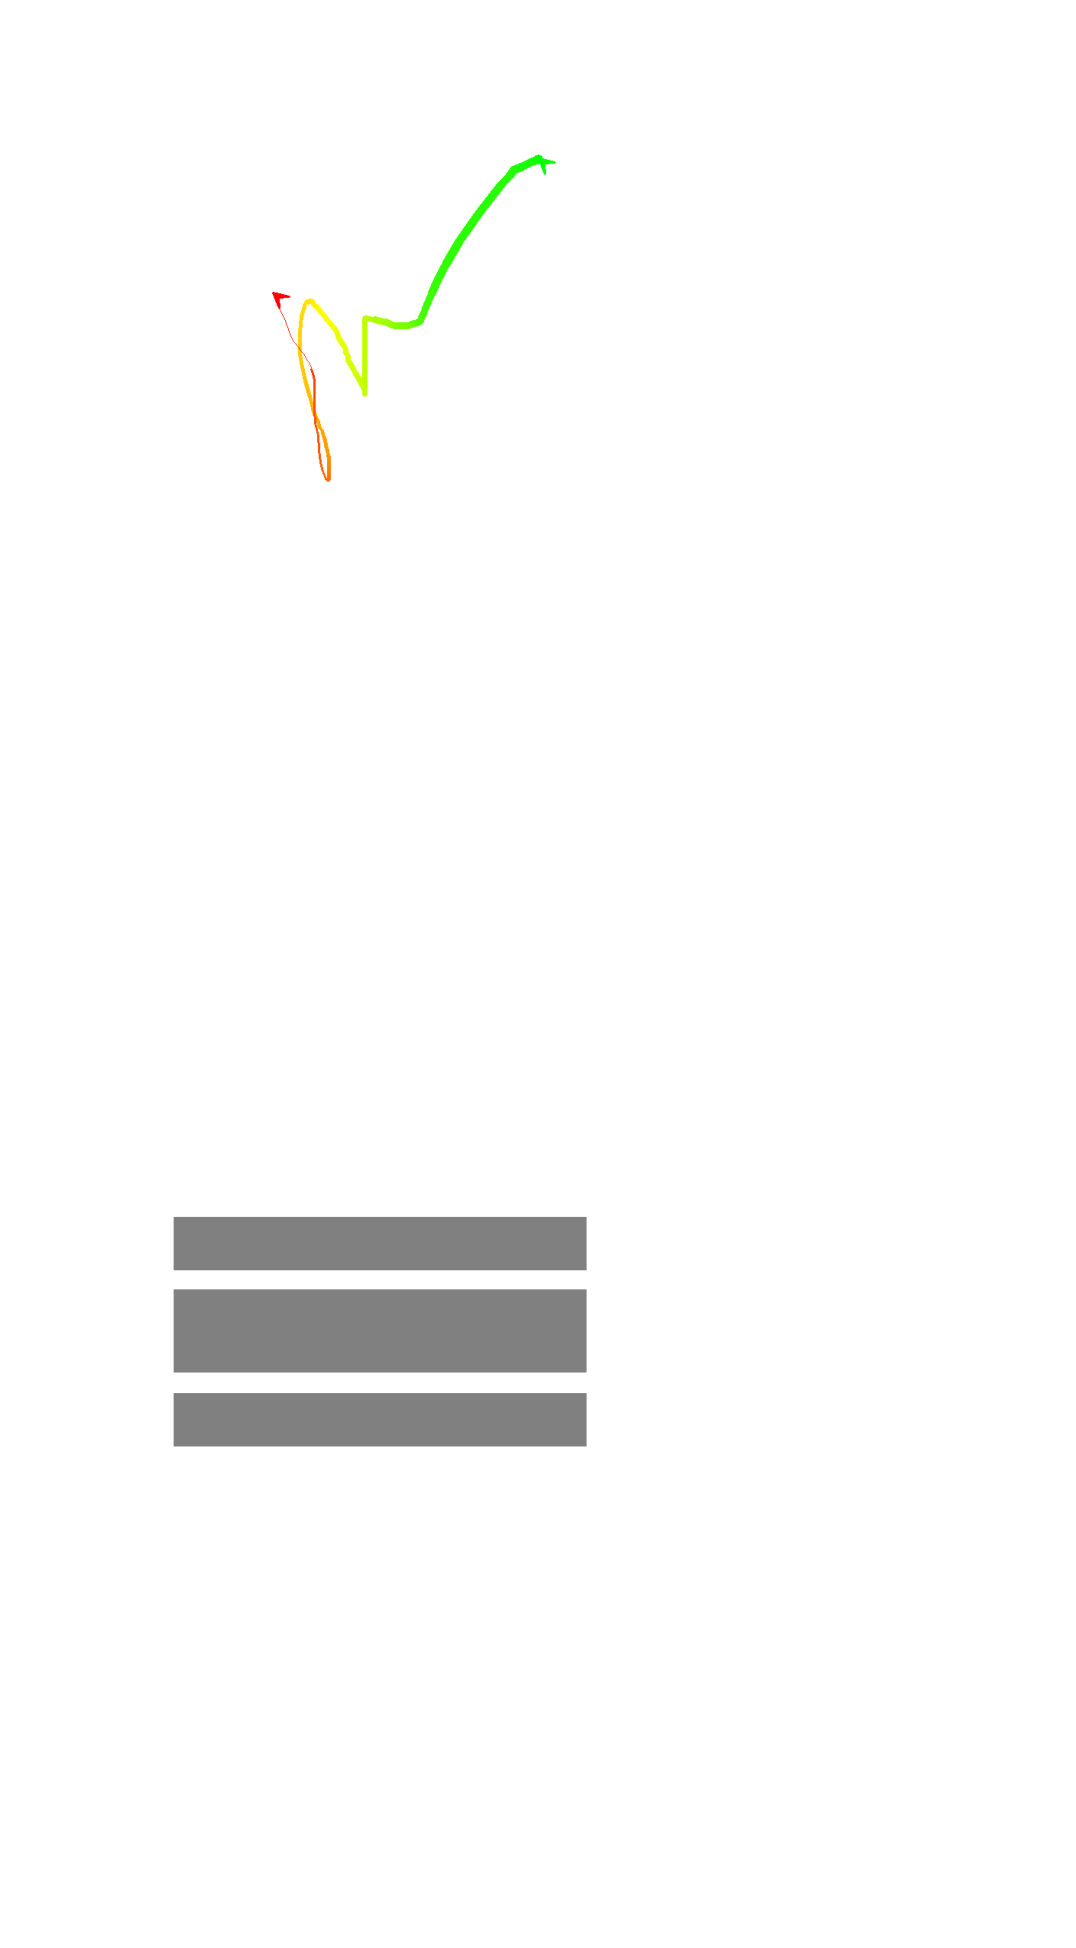

In [291]:
folder_path = os.path.join(visualizations_data_dir, 'colored-trajectories-with-variable-line-thickness/with-ads-masks/')
img_path = os.path.join(folder_path, (trial_id + '.png'))
visualization_img = cv2.imread(img_path)

plot_image(visualization_img)